In [178]:
import numpy as np
import cv2
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt

In [179]:
num_ans = 5
num_ques = 5

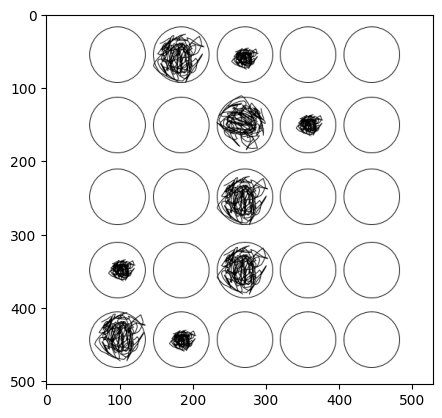

In [180]:
image = cv2.imread('omr4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

answers = {0: 1, 
           1: 2, 
           2: 1,
           3: 2, 
           4: 1}
Digital = True

plt.imshow(image)

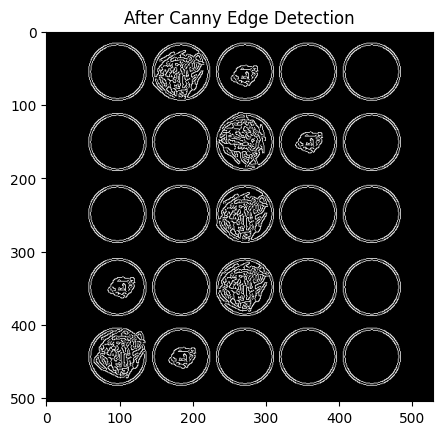

In [181]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blurred, 75, 200)
plt.title('After Canny Edge Detection')
plt.imshow(edged, cmap = 'gray')

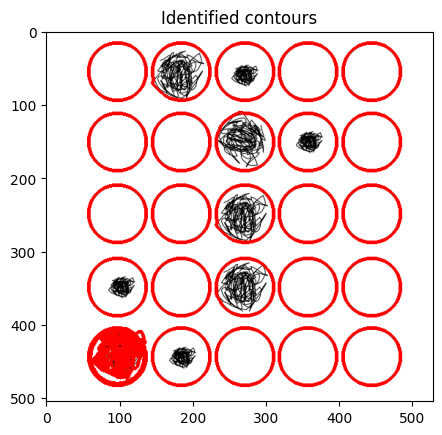

In [182]:
tmp_img = image.copy()
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(tmp_img, contours[0], -1, (255, 0, 0), 3) 
plt.title('Identified contours')
plt.imshow(tmp_img)

In [183]:
contours = imutils.grab_contours(contours)
docCnt = None
if len(contours) > 0:
    contours = sorted(contours, key=cv2.contourArea, reverse = True)

In [184]:
for i in contours:
    perimeter = cv2.arcLength(i, True)
    approx = cv2.approxPolyDP(i, 0.02*perimeter, True)
    if len(approx) == 4:
      docCnt = approx
      break

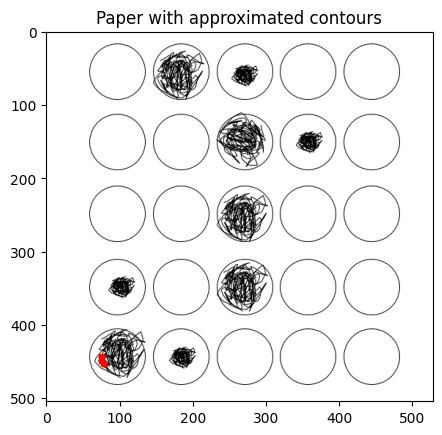

In [185]:
img_tmp = image.copy()
cv2.drawContours(img_tmp, docCnt, -1, (255,0,0), 10)
plt.title('Paper with approximated contours')
plt.imshow(img_tmp)

In [186]:
if docCnt is not None and not Digital:
    mypaper = four_point_transform(image, docCnt.reshape(4,2))
    gypaper = four_point_transform(gray, docCnt.reshape(4,2))

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(mypaper)
    ax[0].set_title('RGB Paper')
    ax[1].imshow(gypaper, cmap='gray')
    ax[1].set_title('Gray Paper')
    plt.show()
else: 
    print('No paper contours found')
    mypaper = image
    gypaper = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

No paper contours found


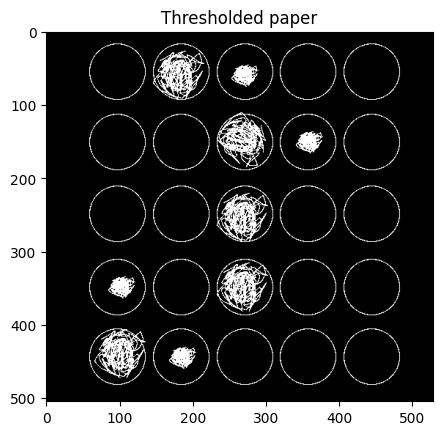

In [187]:
thresholded = cv2.threshold(gypaper, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) [1]
plt.title('Thresholded paper')
plt.imshow(thresholded, cmap='gray')

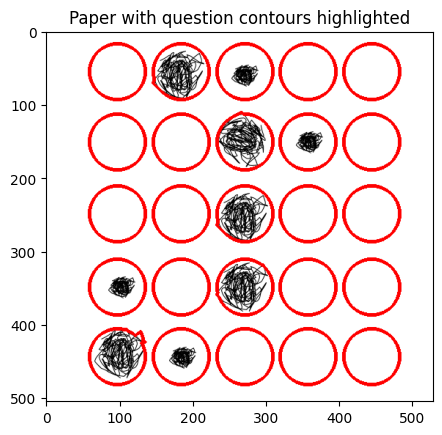

In [188]:
contours = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
qcontours = []
for j in contours:
    (x, y, w, h) = cv2.boundingRect(j)
    ar = w / float(h)
    if w>=20 and h>=20 and ar>=0.9 and ar<=1.1:
      qcontours.append(j)

img_tmp = mypaper.copy()
cv2.drawContours(img_tmp, qcontours, -1, (255,0,0), 3)
plt.title('Paper with question contours highlighted')
plt.imshow(img_tmp)

In [189]:
contours = sorted(qcontours, key=lambda c:cv2.boundingRect(c)[1])

In [190]:
correct=0
sorted_contours = []

for (q,i) in enumerate(np.arange(0, len(qcontours), num_ans)):
    contours = qcontours[i:i+num_ans]
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    bubbled = None

    for(j,c) in enumerate(contours):
      mask = np.zeros(thresholded.shape, dtype="uint8")
      cv2.drawContours(mask, [c], -1, 255, -1)
      mask = cv2.bitwise_and(thresholded, thresholded, mask = mask)
      total = cv2.countNonZero(mask)
      if bubbled is None or total > bubbled[0]:
        bubbled = (total,j)

    color = (255,0,0)
    k = answers[q]
    if k==bubbled[1]:
      color = (0,255,0)
      correct +=1
    cv2.drawContours(mypaper, [contours[k]], -1, color, 3)

In [191]:
for i, contour in enumerate(contours, 1):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.drawContours(gypaper, [contour], -1, (0, 255, 0), 2)
    cv2.putText(gypaper, str(i), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

Score: 60.00%


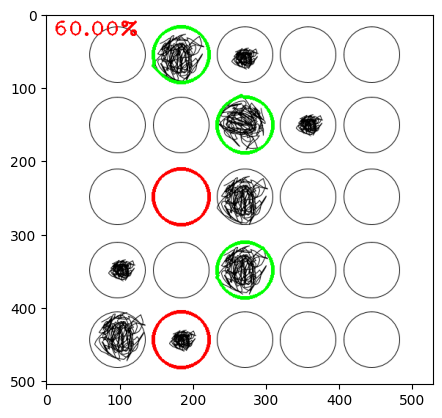

In [192]:
score = (correct / num_ques) * 100
print("Score: {:.2f}%".format(score))
cv2.putText(mypaper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)

plt.imshow(mypaper)